In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
sys.path.insert(0,'./bin')
from pipeline_utils.vrs_utils import get_vrs, grange
from tqdm import tqdm_notebook
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

In [3]:
df1 = pd.read_csv("Alveolar_cells_Type_I_Merged_Batches.csv", index_col="gene_id")
df2 = pd.read_csv("Alveolar_cells_Type_II_Merged_Batches.csv", index_col="gene_id")

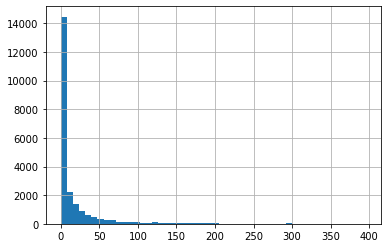

In [4]:
(df1 > 0).sum(axis=1).hist(bins=50)

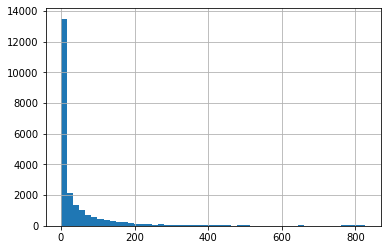

In [5]:
(df2 > 0).sum(axis=1).hist(bins=50)

In [6]:
def BI_kurtosis(df):
    n = df.shape[0]
    K = df.kurt()
    skewness = df.skew()
    return (skewness ** 2 + 1) / (K + (3 * (n-1) ** 2) / ((n-2) * (n-3)))

def _get_vrs(toy):
    threshold_range = grange(0.5, np.nanquantile(toy,0.975))
#     threshold_range = grange(*np.nanquantile(toy,[0.025, 0.975]))
    values = [get_vrs(toy, x) for x in (threshold_range)]
    return threshold_range[np.nanargmin(values)]

def plot(name, bins, ax, invert_labels=False):
    toy = np.concatenate([df1.loc[name], df2.loc[name]])
    
#     print("Type I  BI: ", BI_kurtosis(df1.loc[name]))
#     print("Type II BI: ", BI_kurtosis(df2.loc[name]))
#     print("Combine BI: ", BI_kurtosis(pd.Series(toy)))
    
    true_labels = np.concatenate([
        np.zeros(len(df1.loc[name])),
        np.ones(len(df2.loc[name]))
    ])
    if invert_labels:
        true_labels = 1 - true_labels
    
#     print(true_labels)
    scores = []
    
    toy_0 = toy[toy > 0]
    vrs_threshold = _get_vrs(toy)
    vrs_labels = (toy >= vrs_threshold).astype(int)
    scores += [accuracy_score(true_labels, vrs_labels), f1_score(true_labels, vrs_labels), matthews_corrcoef(true_labels, vrs_labels)]
    
    if len(toy_0) < 120:
        upper = sorted(toy_0)[-3:]
    else:
        upper = np.quantile(toy_0, 0.975)
    fm_threshold = upper / 10
    fm_labels = (toy >= fm_threshold).astype(int)
    scores += [accuracy_score(true_labels, fm_labels), f1_score(true_labels, fm_labels), matthews_corrcoef(true_labels, fm_labels)]
        
    if len(toy_0) < 120:
        lower = sorted(toy_0)[:3]
    else:
        lower = np.quantile(toy_0, 0.025)
    gtme_threshold = gmean([upper, lower])
    gtme_labels = (toy >= gtme_threshold).astype(int)
    scores += [accuracy_score(true_labels, gtme_labels), f1_score(true_labels, gtme_labels), matthews_corrcoef(true_labels, gtme_labels)]
    
    zero_labels = (toy >= 0.5).astype(int)
    scores += [accuracy_score(true_labels, zero_labels), f1_score(true_labels, zero_labels), matthews_corrcoef(true_labels, zero_labels)]
    
    bottom, _ = np.histogram(df1.loc[name], range=(-0.5, bins-0.5), bins=bins)
    sns.distplot(df1.loc[name], kde=False, hist_kws={"range": (-0.5, bins-0.5)}, bins=bins, ax=ax)
    sns.distplot(df2.loc[name], kde=False, hist_kws={"range": (-0.5, bins-0.5), "bottom": bottom}, bins=bins, ax=ax)
    sns.distplot([vrs_threshold], kde=False, hist=False, rug=True, rug_kws={"height": 0.95, "linewidth": 2}, label="VRS", ax=ax)
    sns.distplot([fm_threshold], kde=False, hist=False, rug=True, rug_kws={"height": 0.95, "linewidth": 2}, label="FM", ax=ax)
    sns.distplot([gtme_threshold], kde=False, hist=False, rug=True, rug_kws={"height": 0.95, "linewidth": 2}, label="GTME", ax=ax)   
    ax.legend()
    ax.set_xlabel("UMI")
    ax.set_ylabel("Count")
    ax.set_title(name)
    return scores

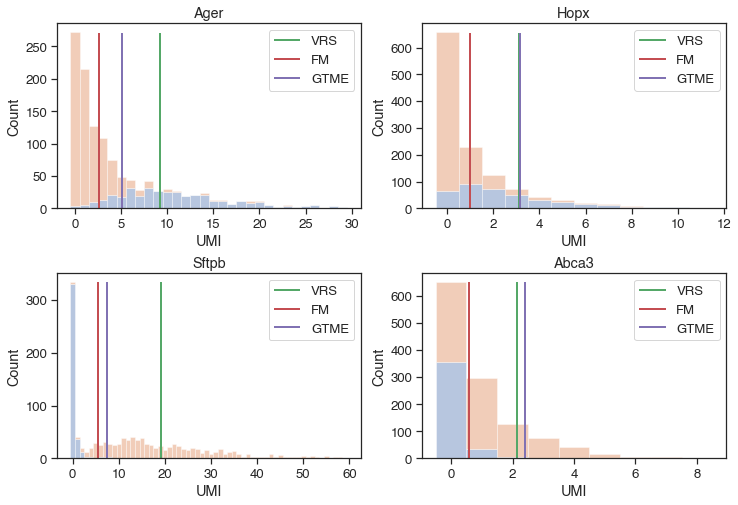

In [7]:
sns.set(font_scale=1.2, style="ticks", font="Helvetica")
scores = []
_, axs = plt.subplots(2,2, figsize=(12,8))
plt.subplots_adjust(hspace=0.35)
scores += [plot("Ager", 30, axs[0,0], True)]
scores += [plot("Hopx", 12, axs[0,1], True)]
scores += [plot("Sftpb", 60, axs[1,0])]
scores += [plot("Abca3", 9, axs[1,1])]
plt.show()

In [8]:
scores += [list(np.mean(scores, axis=0))]

In [9]:
pd.DataFrame(
    scores,
    index=["Ager", "Hopx", "Sftpb", "Abca3", "mean"],
    columns=pd.MultiIndex.from_product([["VRS", "FM", "GTME", "0.5"], ["Accuracy", "F1", "MCC"]])
)

VRS                            FM                          GTME  \
       Accuracy        F1       MCC  Accuracy        F1       MCC  Accuracy   
Ager   0.837152  0.682616  0.620153  0.796236  0.751249  0.630298  0.902619   
Hopx   0.751227  0.430712  0.386125  0.754501  0.687500  0.517153  0.751227   
Sftpb  0.607201  0.591837  0.433096  0.934534  0.949812  0.861108  0.896890   
Abca3  0.440262  0.296296  0.248174  0.724223  0.758769  0.505901  0.440262   
mean   0.658961  0.500365  0.421887  0.802373  0.786832  0.628615  0.747750   

                                0.5                      
             F1       MCC  Accuracy        F1       MCC  
Ager   0.845254  0.774901  0.539280  0.581413  0.352977  
Hopx   0.430712  0.386125  0.754501  0.687500  0.517153  
Sftpb  0.918075  0.797476  0.943535  0.959767  0.871699  
Abca3  0.296296  0.248174  0.724223  0.758769  0.505901  
mean   0.622584  0.551669  0.740385  0.746862  0.561933

In [10]:
pd.DataFrame(
    scores,
    index=["Ager", "Hopx", "Sftpb", "Abca3", "mean"],
    columns=pd.MultiIndex.from_product([["VRS", "FM", "GTME", "0.5"], ["Accuracy", "F1", "MCC"]])
).to_csv("umi_threshold_misclassification.csv")